# Training the DL model for target action recognition
## Selected action -- Sharpening knives

In [1]:
# Import Libraries
import sys

sys.path.append("./")

import numpy as np
import os
from pathlib import Path
import time
import warnings

from sklearn.metrics import accuracy_score
import scrapbook as sb
import torch
import torchvision

# Main library from modified Microsoft-computervision-recipes
from utils_cv.action_recognition.dataset import VideoDataset
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path

system_info()
warnings.filterwarnings('ignore')
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/yangze2065/anaconda3/envs/cv/lib/python3.7/site-packages/scrapbook/__init__.py:8: FutureWarning: 'nteract-scrapbook' package has been renamed to `scrapbook`. No new releases are going out for this old package name.
  warnings.warn("'nteract-scrapbook' package has been renamed to `scrapbook`. No new releases are going out for this old package name.", FutureWarning)


3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0] 

PyTorch 1.3.1 

Torch-vision 0.4.2 

Available devices:
0: GeForce RTX 2080 Ti


## Check data directory

In [2]:
data_path()

PosixPath('/home/yangze2065/CSCE636-Spring2021-master/data')

## Prepare training and validation dataset
### The annotated dataset is downloaded from [DeepMind - kinetics700](https://deepmind.com/research/open-source/kinetics)

In [5]:
# Your data
DATA_PATH = data_path() / "./kinetics700_2020/"

# Number of consecutive frames used as input to the DNN. Use: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8

# Number of training epochs
EPOCHS = 20

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 10

# Learning rate
LR = 0.0001

In [6]:
# List of classes
os.listdir(Path(DATA_PATH))

['false', 'sharpening_knives']

In [7]:
# The train/test split ratio is 75/25
data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, sample_length=MODEL_INPUT_SIZE)

In [8]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 90 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fbe54f08350>     
Testing dataset: 29 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fbe4f6d4890>


<Figure size 432x288 with 0 Axes>

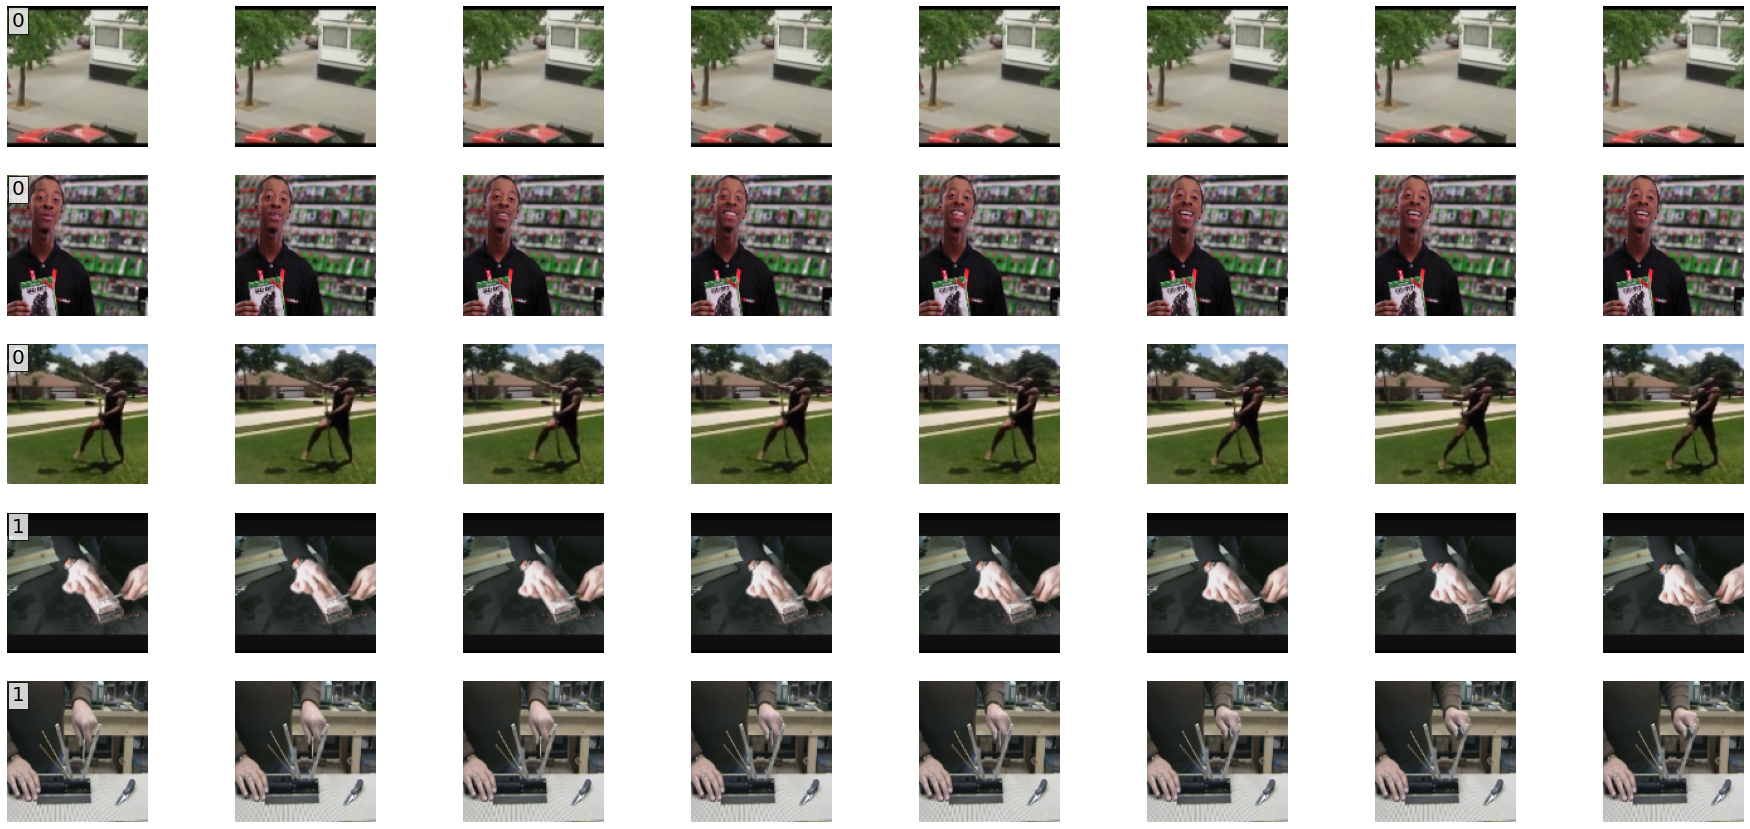

In [9]:
# Display 5 random selected video frames from training data
data.show_batch(rows=5, train_or_test="train")

## Loading the initial weight from [pretrained model](https://github.com/moabitcoin/ig65m-pytorch)
### The model I used in this notebook was R(2+1)D trained on instegram 65 million videos. There is another option to use pretrained model of kinetics400 dataset
### [R(2+1)D_8frame_ig65m](https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth)
### [R(2+1)D_32frame_ig65m](https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip8_ft_kinetics_from_ig65m-0aa0550b.pth)
### [R(2+1)D_8frame_kinetics](https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip32_ig65m_from_scratch-449a7af9.pth)
### [R(2+1)D_32frame_kinetics](https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip32_ft_kinetics_from_ig65m-ade133f1.pth)

In [9]:
learner = VideoLearner(data, num_classes=2, base_model = "ig65m") # Optional base model = "kinetics"

Loading r2plus1d_34_8_ig65m model


Using cache found in /home/yangze2065/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [10]:
learner.model.fc

Linear(in_features=512, out_features=2, bias=True)

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
 Phase train: batch 10 of 43
 Phase train: batch 20 of 43
 Phase train: batch 30 of 43
 Phase train: batch 40 of 43
train took 52.00 sec | loss = 0.7503 | top1_acc = 50.9434  
 Phase valid: batch 10 of 15
valid took 21.20 sec | loss = 0.6856 | top1_acc = 53.9007  
Epoch 2 =========================================================
lr=[0.0001]
 Phase train: batch 10 of 43
 Phase train: batch 20 of 43
 Phase train: batch 30 of 43
 Phase train: batch 40 of 43
train took 52.51 sec | loss = 0.6477 | top1_acc = 62.0283  
 Phase valid: batch 10 of 15
valid took 23.25 sec | loss = 0.5791 | top1_acc = 77.3050  
Epoch 3 =========================================================
lr=[0.0001]
 Phase train: batch 10 of 43
 Phase train: batch 20 of 43
 Phase train: batch 30 of 43
 Phase train: batch 40 of 43
train took 56.14 sec | loss = 0.5554 | top1_acc = 75.7076  
 Phase valid: batch 10 of 15


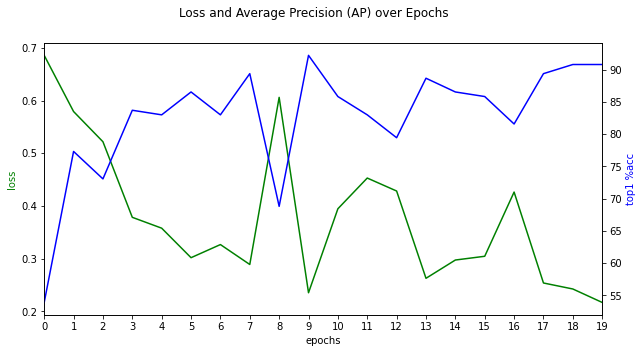

In [11]:
learner.fit(lr=LR, epochs=EPOCHS)

In [12]:
ret = learner.evaluate()

141 samples of torch.Size([3, 8, 112, 112])
Processsing 100 of 141 samples..
Avg. inference time per video (141 clips) = 104.49 ms
Video prediction accuracy = 0.94
Clip prediction accuracy = 0.89


## Let's try one video that is never seen by the model

In [13]:
unknown_vid0 = str(data_path()/"bgVVJxpqRTc.mp4")
unknown_vid1 = str(data_path()/"5sXubRXt6Q0.mp4")

Total frames = 600


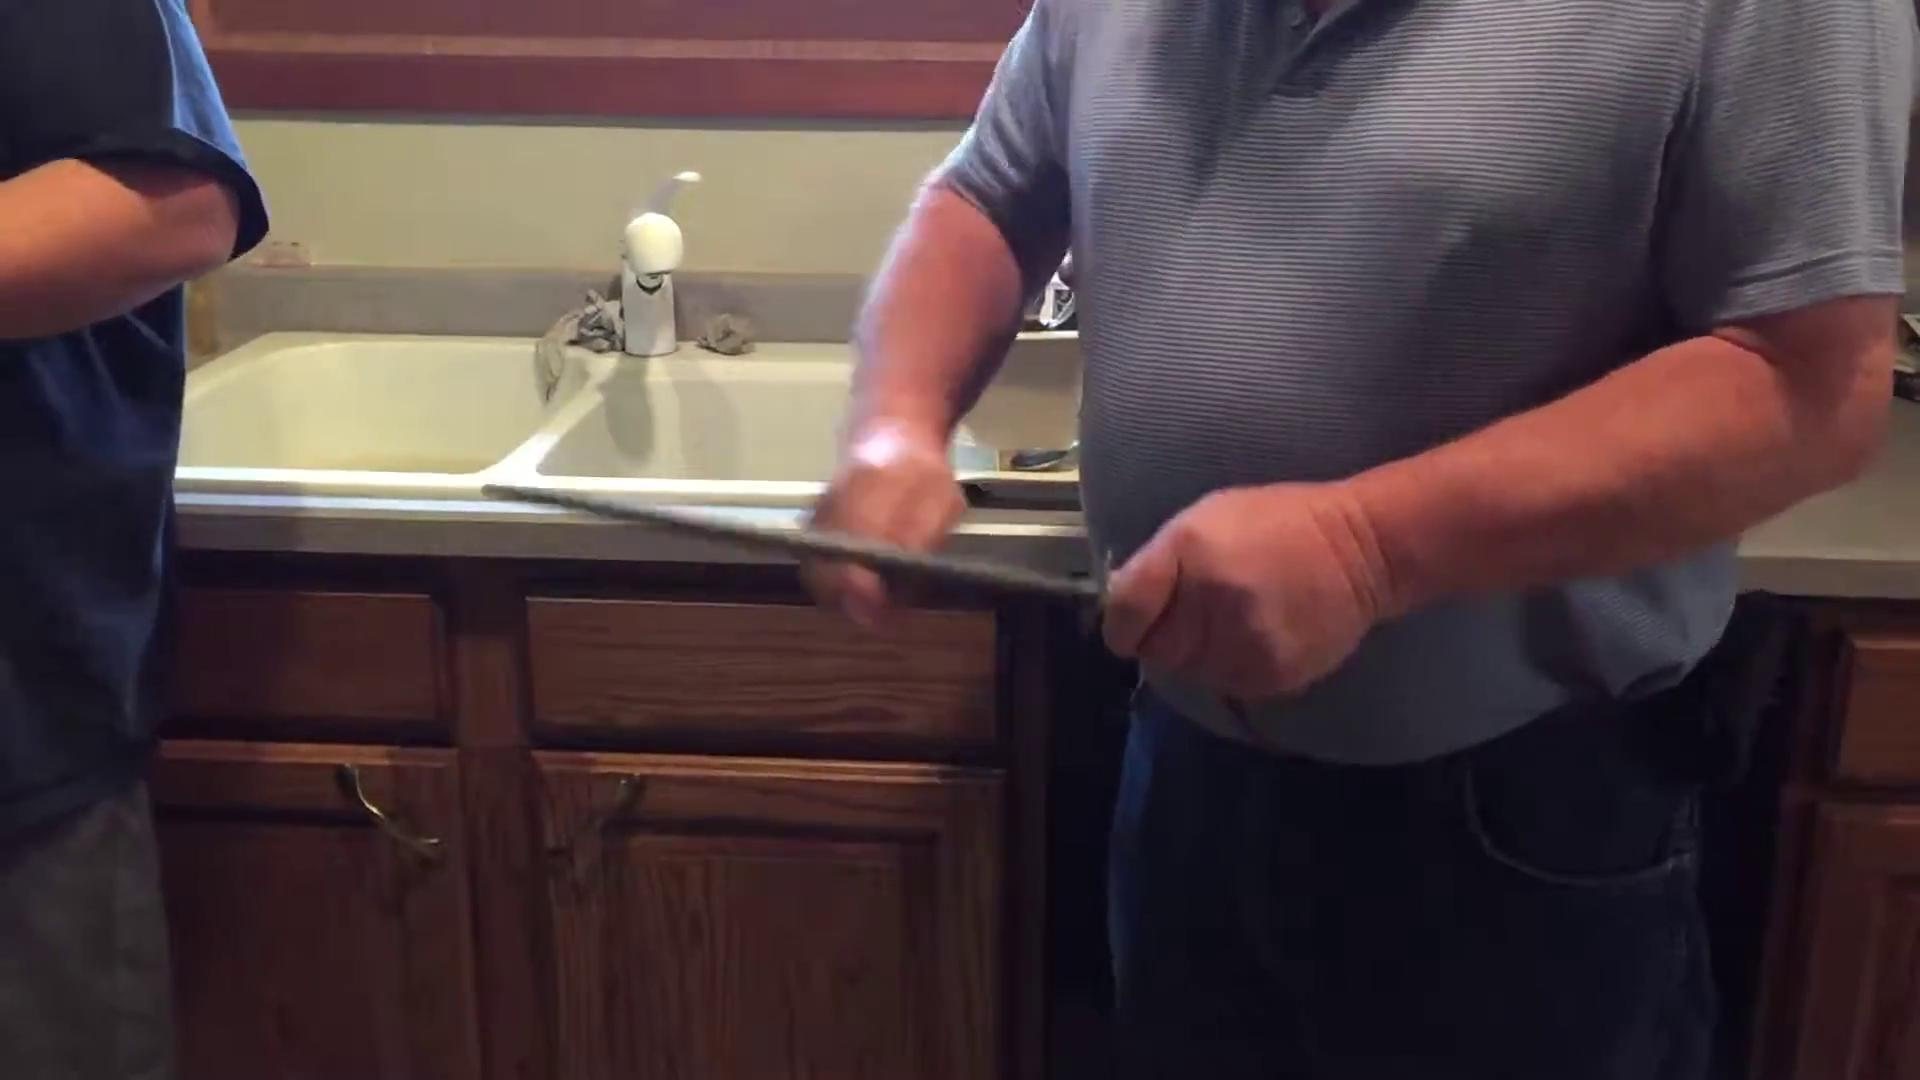

In [14]:
example = learner.predict_video(unknown_vid0)

## Save the model

In [15]:
learner.save(model_path = "./checkpoints/R21D8_sharpening_knives.pt")